In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pydot

In [2]:
def get_data(day: str):
    df = pd.read_csv(f"./data/{day}.csv", sep=";", parse_dates=["timestamp"])
    df["weekday"] = day
    return df

In [3]:
# Creating DataFrames for each day of the week
week_days=["monday", "tuesday", "wednesday", "thursday", "friday"]
for day in week_days:
    locals()[day] = get_data(day)

In [4]:
monday

,timestamp,customer_no,location,weekday
0,2019-09-02 07:03:00,1,dairy,monday
1,2019-09-02 07:03:00,2,dairy,monday
2,2019-09-02 07:04:00,3,dairy,monday
3,2019-09-02 07:04:00,4,dairy,monday
4,2019-09-02 07:04:00,5,spices,monday
...,...,...,...,...
4879,2019-09-02 21:49:00,1442,checkout,monday
4880,2019-09-02 21:49:00,1444,checkout,monday
4881,2019-09-02 21:49:00,1445,dairy,monday
4882,2019-09-02 21:50:00,1446,dairy,monday


In [5]:
# Function to modify 'customer_no' column
def new_customer_no(df):
    df["customer_no"] = df["customer_no"].astype(str) + "_" + df["weekday"].iloc[0]

In [6]:
df_week_days=[monday, tuesday, wednesday, thursday, friday]
for day_df in df_week_days:
    new_customer_no(day_df)

In [7]:
monday

,timestamp,customer_no,location,weekday
0,2019-09-02 07:03:00,1_monday,dairy,monday
1,2019-09-02 07:03:00,2_monday,dairy,monday
2,2019-09-02 07:04:00,3_monday,dairy,monday
3,2019-09-02 07:04:00,4_monday,dairy,monday
4,2019-09-02 07:04:00,5_monday,spices,monday
...,...,...,...,...
4879,2019-09-02 21:49:00,1442_monday,checkout,monday
4880,2019-09-02 21:49:00,1444_monday,checkout,monday
4881,2019-09-02 21:49:00,1445_monday,dairy,monday
4882,2019-09-02 21:50:00,1446_monday,dairy,monday


In [8]:
def add_missing_checkout_location(day_df):
    # Get unique customers who checked out and all customers
    checkout_customers = day_df[day_df["location"] == "checkout"]["customer_no"].unique()
    all_customers = day_df["customer_no"].unique()
    
    # Find customers who haven't checked out
    missing_customers = set(all_customers).difference(checkout_customers)
    
    # Calculate the new timestamp, adding 2 hours to the maximum timestamp in the DataFrame
    new_timestamp = day_df["timestamp"].max() + pd.DateOffset(hours=2)
    
    # Create a DataFrame for missing checkouts
    missing_checkouts_data = {
        "timestamp": [new_timestamp] * len(missing_customers),
        "customer_no": list(missing_customers),
        "location": ["checkout"] * len(missing_customers),
        "weekday": day_df["weekday"].iloc[0]
        }
    
    # Concatenate the original DataFrame and the DataFrame for missing checkouts
    day_df = pd.concat([day_df, pd.DataFrame(missing_checkouts_data)], ignore_index=True)
    
    return day_df

In [9]:
for i, day_df in enumerate(df_week_days):
    df_week_days[i] = add_missing_checkout_location(day_df)

# Update the original dataframe variables with the modified dataframes
monday, tuesday, wednesday, thursday, friday = df_week_days

In [10]:
monday

,timestamp,customer_no,location,weekday
0,2019-09-02 07:03:00,1_monday,dairy,monday
1,2019-09-02 07:03:00,2_monday,dairy,monday
2,2019-09-02 07:04:00,3_monday,dairy,monday
3,2019-09-02 07:04:00,4_monday,dairy,monday
4,2019-09-02 07:04:00,5_monday,spices,monday
...,...,...,...,...
4889,2019-09-02 23:50:00,1439_monday,checkout,monday
4890,2019-09-02 23:50:00,1433_monday,checkout,monday
4891,2019-09-02 23:50:00,1443_monday,checkout,monday
4892,2019-09-02 23:50:00,1447_monday,checkout,monday


In [11]:
def add_entrance_state(df):
    # Find the minimum timestamp for each customer
    min_timestamp_per_customer = df.groupby("customer_no")["timestamp"].min().reset_index()
    
    # Create entrance entries
    one_minute = datetime.timedelta(minutes=1)
    entrance_entries = min_timestamp_per_customer.apply(
        lambda x: {
            "timestamp": x["timestamp"] - one_minute,
            "customer_no": x["customer_no"],
            "location": "entrance"
        },
        axis=1
    )
    
    # Convert entrance entries to a DataFrame
    entrance_entries_df = pd.DataFrame(list(entrance_entries))
    
    # Concatenate original DataFrame and entrance entries DataFrame
    df = pd.concat([df, entrance_entries_df], ignore_index=True)
    
    return df

In [12]:
for i in range(len(df_week_days)):
    df_week_days[i] = add_entrance_state(df_week_days[i])
# Update the original dataframe variables with the modified dataframes
monday, tuesday, wednesday, thursday, friday = df_week_days

In [13]:
monday

,timestamp,customer_no,location,weekday
0,2019-09-02 07:03:00,1_monday,dairy,monday
1,2019-09-02 07:03:00,2_monday,dairy,monday
2,2019-09-02 07:04:00,3_monday,dairy,monday
3,2019-09-02 07:04:00,4_monday,dairy,monday
4,2019-09-02 07:04:00,5_monday,spices,monday
...,...,...,...,...
6336,2019-09-02 17:42:00,997_monday,entrance,NaN
6337,2019-09-02 17:42:00,998_monday,entrance,NaN
6338,2019-09-02 17:43:00,999_monday,entrance,NaN
6339,2019-09-02 07:55:00,99_monday,entrance,NaN


In [14]:
def make_df_proper(coming_data: list):
    # Concatenate the incoming data and reindex
    df = pd.concat(coming_data).set_index('timestamp').sort_index()
    
    # Select necessary columns and rename
    df = df[['customer_no', 'location', 'weekday']].rename(columns={'location': 'location0'})
    
    return df

In [15]:
weekly_data_matrix = make_df_proper([monday, tuesday, wednesday, thursday, friday])
weekly_data_matrix

,customer_no,location0,weekday
timestamp,,,
2019-09-02 07:02:00,2_monday,entrance,NaN
2019-09-02 07:02:00,1_monday,entrance,NaN
2019-09-02 07:03:00,1_monday,dairy,monday
2019-09-02 07:03:00,4_monday,entrance,NaN
2019-09-02 07:03:00,3_monday,entrance,NaN
...,...,...,...
2019-09-06 23:50:00,1496_friday,checkout,friday
2019-09-06 23:50:00,1506_friday,checkout,friday
2019-09-06 23:50:00,1510_friday,checkout,friday


In [16]:
# Group by customer number and resample
weekly_data_matrix = weekly_data_matrix.groupby("customer_no")["location0"].resample(rule="1min").ffill().reset_index()

# Create location1 column by shifting location0 within each customer group
weekly_data_matrix["location1"] = weekly_data_matrix.groupby("customer_no")["location0"].shift(-1)

# Fill missing values in location0 and location1
weekly_data_matrix["location0"].fillna("entrance", inplace=True)
weekly_data_matrix["location1"].fillna("checkout", inplace=True)

In [17]:
weekly_data_matrix[weekly_data_matrix["customer_no"] == "1002_monday"]

,customer_no,timestamp,location0,location1
130,1002_monday,2019-09-02 17:44:00,entrance,drinks
131,1002_monday,2019-09-02 17:45:00,drinks,drinks
132,1002_monday,2019-09-02 17:46:00,drinks,drinks
133,1002_monday,2019-09-02 17:47:00,drinks,checkout
134,1002_monday,2019-09-02 17:48:00,checkout,checkout


In [18]:
weekly_data_matrix[weekly_data_matrix["customer_no"] == "1002_monday"]

,customer_no,timestamp,location0,location1
130,1002_monday,2019-09-02 17:44:00,entrance,drinks
131,1002_monday,2019-09-02 17:45:00,drinks,drinks
132,1002_monday,2019-09-02 17:46:00,drinks,drinks
133,1002_monday,2019-09-02 17:47:00,drinks,checkout
134,1002_monday,2019-09-02 17:48:00,checkout,checkout


In [19]:
weekly_data_matrix[weekly_data_matrix["customer_no"] == "1000_monday"]

,customer_no,timestamp,location0,location1
3,1000_monday,2019-09-02 17:43:00,entrance,dairy
4,1000_monday,2019-09-02 17:44:00,dairy,dairy
5,1000_monday,2019-09-02 17:45:00,dairy,dairy
6,1000_monday,2019-09-02 17:46:00,dairy,dairy
7,1000_monday,2019-09-02 17:47:00,dairy,dairy
8,1000_monday,2019-09-02 17:48:00,dairy,dairy
9,1000_monday,2019-09-02 17:49:00,dairy,drinks
10,1000_monday,2019-09-02 17:50:00,drinks,checkout
11,1000_monday,2019-09-02 17:51:00,checkout,checkout


In [20]:
weekly_data_matrix.fillna("checkout", inplace=True)
#weekly_data_matrix.to_csv("./simulated_market_table")
weekly_data_matrix

,customer_no,timestamp,location0,location1
0,1000_friday,2019-09-06 17:18:00,entrance,fruit
1,1000_friday,2019-09-06 17:19:00,fruit,checkout
2,1000_friday,2019-09-06 17:20:00,checkout,checkout
3,1000_monday,2019-09-02 17:43:00,entrance,dairy
4,1000_monday,2019-09-02 17:44:00,dairy,dairy
...,...,...,...,...
64732,9_tuesday,2019-09-03 07:29:00,dairy,checkout
64733,9_tuesday,2019-09-03 07:30:00,checkout,checkout
64734,9_wednesday,2019-09-04 07:02:00,entrance,spices
64735,9_wednesday,2019-09-04 07:03:00,spices,checkout


In [21]:
transition_ = pd.crosstab(weekly_data_matrix['location0'],
                          weekly_data_matrix['location1'], normalize="index")
transition_

location1,checkout,dairy,drinks,fruit,spices
location0,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.094521,0.759509,0.053505,0.045539,0.046926
drinks,0.210537,0.010637,0.608128,0.085800,0.084897
entrance,0.000000,0.287576,0.153526,0.377435,0.181464
fruit,0.189091,0.089970,0.051443,0.621965,0.047531
spices,0.137560,0.176385,0.148902,0.083030,0.454122


In [22]:
# Make a copy of the original transition matrix
transition_modified_prediction = transition_.copy()

# Define new transition probabilities for "entrance"
entrance_probs = [0.025, 0, 0, 0, 0, 0]
transition_modified_prediction["entrance"] = entrance_probs

# Modify the transition probability from "entrance" to "checkout"
transition_modified_prediction["checkout"].iloc[0] = 0.975
transition_modified_prediction

location1,checkout,dairy,drinks,fruit,spices,entrance
location0,,,,,,
checkout,0.975000,0.000000,0.000000,0.000000,0.000000,0.025
dairy,0.094521,0.759509,0.053505,0.045539,0.046926,0.000
drinks,0.210537,0.010637,0.608128,0.085800,0.084897,0.000
entrance,0.000000,0.287576,0.153526,0.377435,0.181464,0.000
fruit,0.189091,0.089970,0.051443,0.621965,0.047531,0.000
spices,0.137560,0.176385,0.148902,0.083030,0.454122,0.000


In [23]:
weekly_data_animation=make_df_proper([monday, tuesday, wednesday, thursday, friday])
weekly_data_animation

,customer_no,location0
timestamp,,
2019-09-02 07:02:00,2_monday,entrance
2019-09-02 07:02:00,1_monday,entrance
2019-09-02 07:03:00,1_monday,dairy
2019-09-02 07:03:00,4_monday,entrance
2019-09-02 07:03:00,3_monday,entrance
...,...,...
2019-09-06 23:50:00,1509_friday,checkout
2019-09-06 23:50:00,1496_friday,checkout
2019-09-06 23:50:00,1506_friday,checkout


In [24]:
# Group by customer number and resample, forward fill the locations
weekly_data_animation = (
    weekly_data_animation
    .groupby("customer_no")["location0"]
    .resample(rule="1min").ffill().reset_index()
)

In [25]:
def get_next_locations(df):
    # Get unique locations from the initial column 'location0'
    unique_locations = df["location0"].unique()
    
    for i in range(len(unique_locations) + 15):
        # Shift the locations for each customer and assign to the next column
        location_nex=df.groupby("customer_no")[f"location{i}"].transform(lambda x: x.shift(-1))
        df[f"location{i + 1}"] = location_nex
        df.fillna("checkout", inplace=True)
    
    return df


In [26]:
get_next_locations(weekly_data_animation)

,customer_no,timestamp,location0,location1,location2,location3,location4,location5,location6,location7,...,location12,location13,location14,location15,location16,location17,location18,location19,location20,location21
0,1000_friday,2019-09-06 17:18:00,entrance,fruit,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
1,1000_friday,2019-09-06 17:19:00,fruit,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
2,1000_friday,2019-09-06 17:20:00,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
3,1000_monday,2019-09-02 17:43:00,entrance,dairy,dairy,dairy,dairy,dairy,dairy,drinks,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
4,1000_monday,2019-09-02 17:44:00,dairy,dairy,dairy,dairy,dairy,dairy,drinks,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64732,9_tuesday,2019-09-03 07:29:00,dairy,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
64733,9_tuesday,2019-09-03 07:30:00,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
64734,9_wednesday,2019-09-04 07:02:00,entrance,spices,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout
64735,9_wednesday,2019-09-04 07:03:00,spices,checkout,checkout,checkout,checkout,checkout,checkout,checkout,...,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout,checkout


In [29]:
transition = pd.crosstab(weekly_data_animation['location0'], weekly_data_animation['location1'], normalize="index")
transition

location1,checkout,dairy,drinks,fruit,spices
location0,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.094521,0.759509,0.053505,0.045539,0.046926
drinks,0.210537,0.010637,0.608128,0.085800,0.084897
entrance,0.000000,0.287576,0.153526,0.377435,0.181464
fruit,0.189091,0.089970,0.051443,0.621965,0.047531
spices,0.137560,0.176385,0.148902,0.083030,0.454122


In [30]:
# Make a copy of the original transition matrix
transition_modified_animation=transition.copy()

# Define new transition probabilities for "entrance"
entrance_probs = [0.025, 0, 0, 0, 0, 0]
transition_modified_animation["entrance"] = entrance_probs

# Modify the transition probability from "entrance" to "checkout"
transition_modified_animation["checkout"].iloc[0] = 0.975
transition_modified_animation

location1,checkout,dairy,drinks,fruit,spices,entrance
location0,,,,,,
checkout,0.975000,0.000000,0.000000,0.000000,0.000000,0.025
dairy,0.094521,0.759509,0.053505,0.045539,0.046926,0.000
drinks,0.210537,0.010637,0.608128,0.085800,0.084897,0.000
entrance,0.000000,0.287576,0.153526,0.377435,0.181464,0.000
fruit,0.189091,0.089970,0.051443,0.621965,0.047531,0.000
spices,0.137560,0.176385,0.148902,0.083030,0.454122,0.000


In [33]:
def plot_matrix(df):
    # Set the plot size and font family
    plt.rcParams['figure.figsize'] = (6, 5)
    plt.rcParams['font.family'] = "serif"
    
    # Plot a heatmap of the DataFrame
    sns.heatmap(df, cmap='coolwarm', annot=True)
    
    # Print the sum of each row in the DataFrame
    print(df.sum(axis=1))


location0
checkout    1.0
dairy       1.0
drinks      1.0
entrance    1.0
fruit       1.0
spices      1.0
dtype: float64


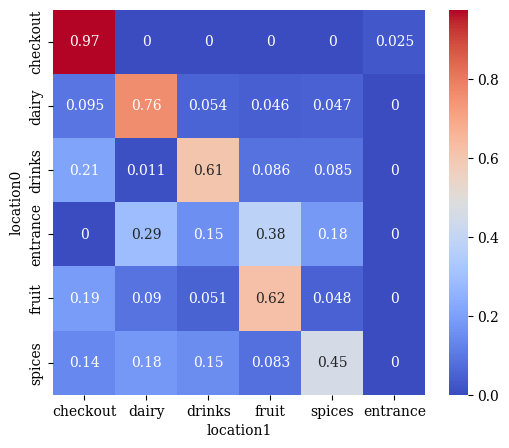

In [34]:
plot_matrix(transition_modified_animation)

/tmp/ipykernel_16401/4037710437.py:28: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')


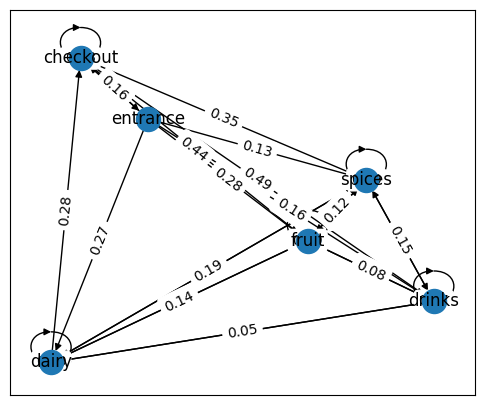

In [29]:
Q = transition_modified_prediction.round(2)
states = ['checkout', 'dairy', 'drinks', 'fruit', 'spices', "entrance"]

# create a function that maps transition probability dataframe
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx, col)] = Q.loc[idx, col]
    return edges

edges_wts = _get_markov_edges(Q)

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)

# edges represent transition probabilities
for k, v in edges_wts.items():
    if v > 0.0:
        tmp_origin, tmp_destination = k[0], k[1]
        G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for the plot
edge_labels = {(n1, n2): d['label'] for n1, n2, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# write the graph to a DOT file
nx.drawing.nx_pydot.write_dot(G, './markov_data/markov.dot')

# load the graph from the DOT file and save as an image
(graph,) = pydot.graph_from_dot_file('./markov_data/markov.dot')
graph.write_png('./markov_data/markov_diagram.png')


In [30]:
class Customer:

    def __init__(self, name):        
        self.name = name
        self.locations =['checkout', 'dairy', 'drinks', 'fruit', 'spices', "entrance"]
        self.budget=np.random.randint(50,100)
        self.state = "entrance"
        self.recipt=0
        self.produckt_prices={'dairy':[0.5,1,1.5,2,3,4,5], 'drinks':[0.5,1,1.5,2,3,4,5], 'fruit':[1,2,3,4,5], 'spices':[1.5,2,3,4.5,5]}
    
    def next_locatons(self ,matrix):
        self.matrix=matrix
        if self.state!="checkout":
            next_location=np.random.choice(self.locations, p=self.matrix.round(4).loc[self.state])
            print(f"Customers moves from {self.state} to {next_location}")
            self.state = next_location

        else:
            next_location=np.random.choice(self.locations, p=self.matrix.round(4).loc[self.state])
            print(f"Customers moves from {self.state} to {next_location}")
            self.state = next_location

        return next_location

    def is_active(self, next_lacation):
        """Returns True if the customer has not reached the checkout yet."""
        if next_lacation == "checkout":
            return False
        else:
            return True
        
    def financial_status(self):
        if self.state!="checkout":
            price=np.random.choice(list(self.produckt_prices[f"{self.state}"]))
            self.recipt+=price
            print(f"Customer is at {self.state} and continue to shop")
        else:
            print(f"Customer is at {self.state} and {self.recipt} is paid")


In [31]:
Bedo=Customer("4_monday")

In [32]:
a=Bedo.next_locatons(transition_modified_prediction)

Customers moves from entrance to dairy


In [33]:
Bedo.is_active(a)

True

In [34]:
Bedo.financial_status()

Customer is at dairy and continue to shop


In [35]:
customer_sample= ["19_monday", "10_monday", "40_monday"]

In [36]:
number_in_stock={'dairy':500, 'drinks':800, 'fruit':300, 'spices':100}

In [37]:
list(number_in_stock.keys())[0]

'dairy'

In [38]:
number_in_stock[list(number_in_stock.keys())[0]]+=1

In [39]:
number_in_stock

{'dairy': 501, 'drinks': 800, 'fruit': 300, 'spices': 100}